### Description of the code:

This code aims to identify critical events related to Swerving based on SHRP2 dataset. 

"The derivation of yaw rate is monitored to find cases where the sigal defines one complete cycle of a sine waveform whose minimum and maximum exceed =-15 deg/s/s within 2s. The minimum speed is 5 m/s (11mph)"

### Generating Example Data

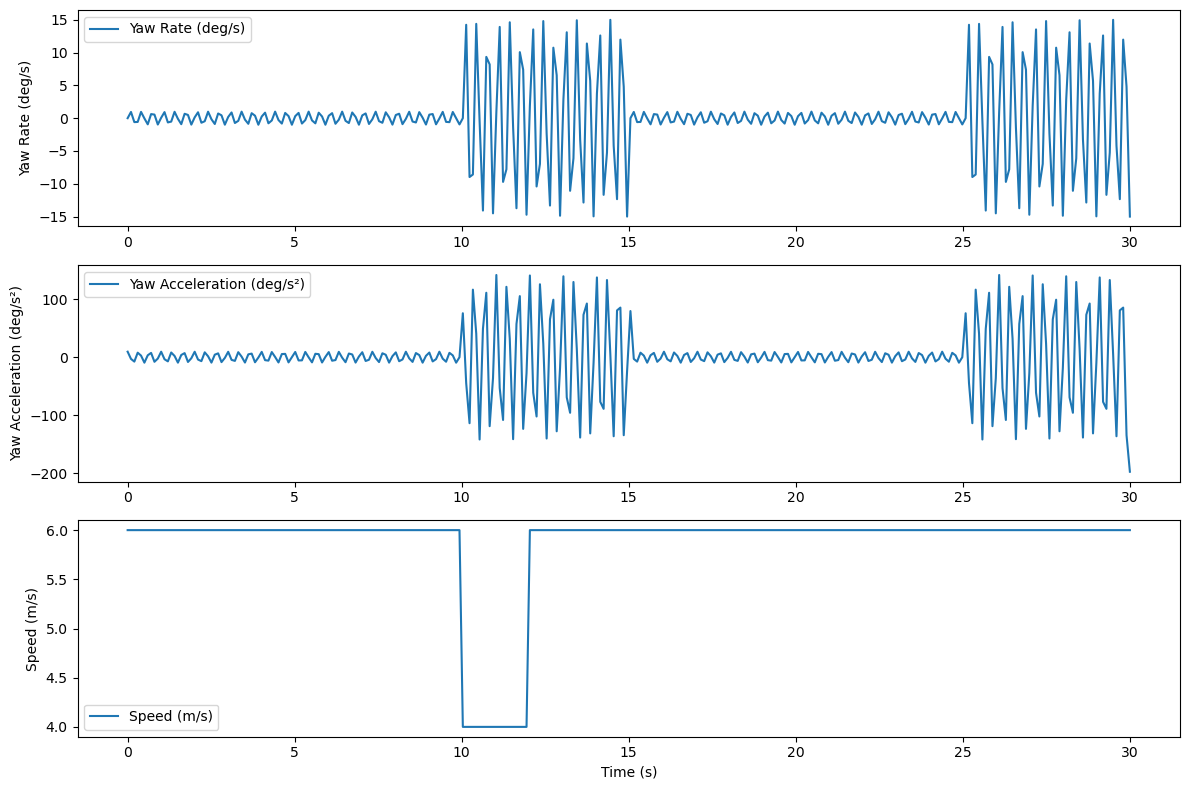

,time,yaw_rate,yaw_acceleration,speed
0,0.000000,0.000000,9.459259,6.0
1,0.100334,0.949090,-2.979728,6.0
2,0.200669,-0.597939,-7.581992,6.0
3,0.301003,-0.572380,7.756481,6.0
4,0.401338,0.958546,2.695309,6.0


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Time parameters
total_duration = 30  # Total duration in seconds
sampling_rate = 10  # Frequency in Hz (10 data points per second)
total_data_points = total_duration * sampling_rate  # Total number of data points

time = np.linspace(0, total_duration, total_data_points)

# Normal conditions (no significant yaw rate changes) for specific intervals
normal_condition_duration = 10 * sampling_rate  # 10 seconds of normal condition in data points
# normal_condition_yaw_rate = np.zeros(normal_condition_duration)
normal_condition_yaw_rate = 1 * np.sin(2 * np.pi * 3 * time[:normal_condition_duration])

# Critical event: Slalom-like movement for two 5-second intervals
critical_event_duration = 5 * sampling_rate  # 5 seconds of critical event in data points
critical_event_yaw_rate = 15 * np.sin(2 * np.pi * 3 * time[:critical_event_duration])

# Combining the normal conditions and critical events
yaw_rate = np.concatenate([
    normal_condition_yaw_rate,  # First 10 seconds normal
    critical_event_yaw_rate,    # 5 seconds critical event
    normal_condition_yaw_rate,  # Next 10 seconds normal
    critical_event_yaw_rate,    # Another 5 seconds critical event
    normal_condition_yaw_rate   # Last 10 seconds normal
])

# Ensure the total length matches the time array
yaw_rate = yaw_rate[:len(time)]

# Derivative of yaw rate (yaw acceleration)
dt = time[1] - time[0]
yaw_acceleration = np.gradient(yaw_rate, dt)

# Speed (constant speed greater than 5 m/s throughout)
speed = np.full_like(time, 6)  # 6 m/s constant speed
speed[100:120] = 4 # setting speed to lower than 6 m/s to make sure the codes works correctly

# Create the DataFrame
complex_data = pd.DataFrame({
    'time': time,
    'yaw_rate': yaw_rate,
    'yaw_acceleration': yaw_acceleration,
    'speed': speed
})

# Plotting the complex data
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(complex_data['time'], complex_data['yaw_rate'], label='Yaw Rate (deg/s)')
plt.ylabel('Yaw Rate (deg/s)')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(complex_data['time'], complex_data['yaw_acceleration'], label='Yaw Acceleration (deg/s²)')
plt.ylabel('Yaw Acceleration (deg/s²)')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(complex_data['time'], complex_data['speed'], label='Speed (m/s)')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.legend()

plt.tight_layout()
plt.show()

# Returning the complex DataFrame for further processing
complex_data.head()


### Detecting the events on test data

In [13]:
from scipy.signal import find_peaks

def detect_swerv_shrp2(data, threshold, time_window, min_speed):
    """
    Detects cycles in yaw acceleration data where the signal defines one complete cycle of a sine waveform 
    whose minimum and maximum exceed the specified threshold within the time window. 
    Only considers data where speed is above the minimum speed.

    :param data: DataFrame with 'time', 'yaw_acceleration', and 'speed' columns
    :param threshold: The threshold for min/max yaw acceleration (deg/s/s)
    :param time_window: Time window to consider for a complete cycle (seconds)
    :param min_speed: Minimum speed to consider for analysis (m/s)
    :return: Indices of time where a complete cycle starts
    """

    detected_cycles = []
    n = len(data)
    window_size = int(time_window / (data['time'].iloc[1] - data['time'].iloc[0]))

    for i in range(n - window_size):
        subset = data.iloc[i:i + window_size]

        if subset['speed'].min() < min_speed:
            continue

        yaw_acc = subset['yaw_acceleration'].values
        # Find peaks and troughs to make sure the waveform is a sine wave
        peaks, _ = find_peaks(yaw_acc)
        troughs, _ = find_peaks(-yaw_acc)
        # Check if there is at least one peak AND one trough
        if len(peaks) > 0 and len(troughs) > 0:
            # Check the amplitude condition
            if yaw_acc[peaks].max() >= threshold and yaw_acc[troughs].min() <= -threshold:
                detected_cycles.append(subset['time'].iloc[0])

    return detected_cycles

# Detecting cycles in the data
threshold_acceleration = 15  # 15 deg/s/s
time_window = 2  # 2 seconds
minimum_speed = 5  # 5 m/s

detected_cycles = detect_swerv_shrp2(complex_data, threshold_acceleration, time_window, minimum_speed)

# Output the detected cycles
print(detected_cycles)

[12.040133779264215, 12.14046822742475, 12.240802675585284, 12.34113712374582, 12.441471571906355, 12.54180602006689, 12.642140468227424, 12.74247491638796, 12.842809364548495, 12.94314381270903, 13.043478260869566, 13.143812709030101, 13.244147157190636, 13.34448160535117, 13.444816053511706, 13.545150501672241, 13.645484949832776, 13.745819397993312, 13.846153846153847, 13.946488294314381, 14.046822742474916, 14.147157190635452, 14.247491638795987, 14.347826086956522, 14.448160535117058, 14.548494983277592, 14.648829431438127, 14.749163879598662, 23.578595317725753, 23.678929765886288, 23.779264214046822, 23.879598662207357, 23.979933110367895, 24.08026755852843, 24.180602006688964, 24.2809364548495, 24.381270903010034, 24.48160535117057, 24.581939799331103, 24.68227424749164, 24.782608695652176, 24.88294314381271, 24.983277591973245, 25.08361204013378, 25.183946488294314, 25.28428093645485, 25.384615384615387, 25.48494983277592, 25.585284280936456, 25.68561872909699, 25.785953177257